# CAR PRICE PREDICTION WITH LINEAR REGRESSION

### Importing libraries

In [1]:
import pandas as pd
import seaborn as sns
import scipy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#### Loading Data

In [2]:
price_df = pd.read_csv('scrap price.csv')

In [3]:
price_df = price_df.drop(['ID','symboling','name'],axis = 1)

#### Data cleaning for dichotomous variables 

Converting data with binary results since Linear Regression reads numbers instead of string values. 

In [4]:
price_df = price_df.replace(['gas','diesel','std','turbo','front','rear'],
                            [0,1,0,1,0,1])

#### Data cleaning for variables with more than 2 results 

In [5]:
for i in ['doornumbers','carbody','drivewheels','fuelsystem','enginetype','cylindernumber']:
    for e, x in enumerate(price_df[i].drop_duplicates()):
        price_df[i] = price_df[i].replace(x, e)

#### Checking for normal distribution in each variable

To use regression analysis it is necessary to start with a correlation analysis. Correlation requires data to be normal. Whith this for loop, a normality test is made through all the variables. For dichotomous or categorical variables it is not necessary. 

In [6]:
def normality_test(df, dec=4 ):
    "normality_test(df,dec)"
    "df: dataframe with variables to calculate"
    "dec: number of decimals for final dataset. 4 if None"
    df_shapiro = pd.DataFrame(columns = ['Variable','P-value','Sentence','Kurtosis'])
    index = 0
    for i in df.columns:
        if i == 'price':
            break
        df_NaN = df[df[i].notnull()]
        kurt = df_NaN[i].kurt()
        stats, p = scipy.stats.shapiro(df_NaN[i])
        index += 1
        if p < 0.05:
            sentence = 'Normal'
        else: 
            sentence = 'Not Normal'

        df_shapiro.loc[index] = [i,p,sentence,kurt]

    df_shapiro = df_shapiro.round(decimals = dec)
    return df_shapiro

In [7]:
normality_df = normality_test(price_df)

In [8]:
normality_df

,Variable,P-value,Sentence,Kurtosis
1,fueltypes,0.0000,Normal,5.5210
2,aspiration,0.0000,Normal,0.8095
3,doornumbers,0.0000,Normal,-1.9579
4,carbody,0.0000,Normal,0.3661
5,drivewheels,0.0000,Normal,-0.6773
6,enginelocation,0.0000,Normal,64.9507
7,wheelbase,0.0000,Normal,1.0170
8,carlength,0.0104,Normal,-0.0829
9,carwidth,0.0000,Normal,0.7028
10,carheight,0.0217,Normal,-0.4438


#### Managing Outliers

Another assumption for correlation analysis is the absence of outliers. So, for every variable with a normal distribution, outliers can be handled with central tendency measures like the mean. 

In [9]:
outlier_counter = {}

In [10]:
for i in price_df.columns:
    if i == 'price':
        break
    if price_df[i].drop_duplicates().count() > 10: # for avoiding categorical variables
        Q1 = price_df[i].quantile(.25)
        Q3 = price_df[i].quantile(.75)
        IQR = (Q3 - Q1)*1.5
        lower = IQR - Q1
        upper = Q3 + IQR
        mean = price_df[i].mean()


        for x in price_df[i]:
            if x < lower or x > upper or pd.isna(x):
                price_df[i].replace(x,mean,inplace = True)

                if i in outlier_counter:
                    outlier_counter[i] +=1
                else:
                    outlier_counter[i] = 1

This code from below allows to see how many outliers had been changed in the dataset for each value

In [11]:
outliers = pd.DataFrame.from_dict(outlier_counter, orient = 'index').reset_index()
outliers.columns = ['Variable','Outliers']
outliers.nlargest(5,'Outliers')

,Variable,Outliers
2,enginesize,10
4,compressionratio,8
5,horsepower,6
1,carwidth,4
8,highwaympg,3


Text(0.5, 1.0, 'Outliers counting for each variable')

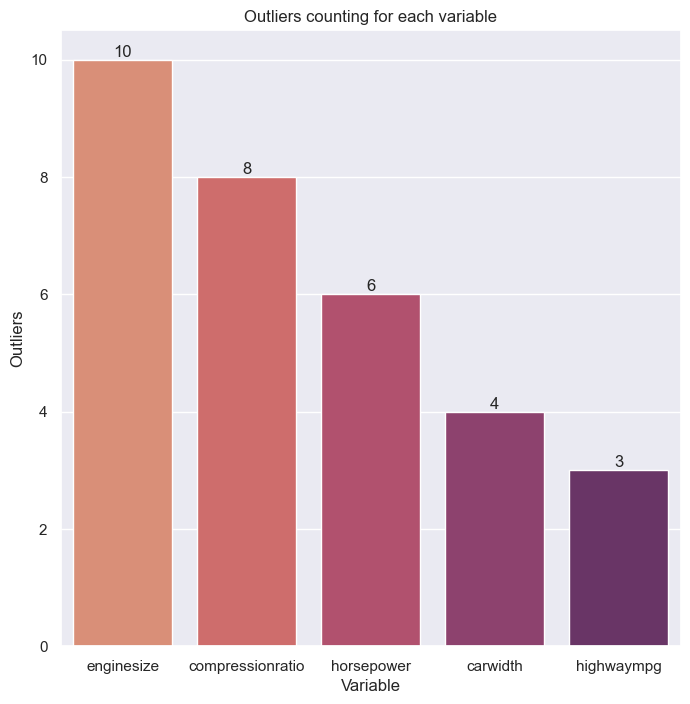

In [12]:
sns.set(rc={'figure.figsize':(8,8)})
barchart = sns.barplot(data=outliers.nlargest(5,'Outliers'), x='Variable', y='Outliers', palette='flare')

for i in barchart.containers:
    barchart.bar_label(i,)

barchart.set_title("Outliers counting for each variable")

### Pearson correlation analysis

Now let's see correlation coefficient R so we can identify independent variables to predict price.

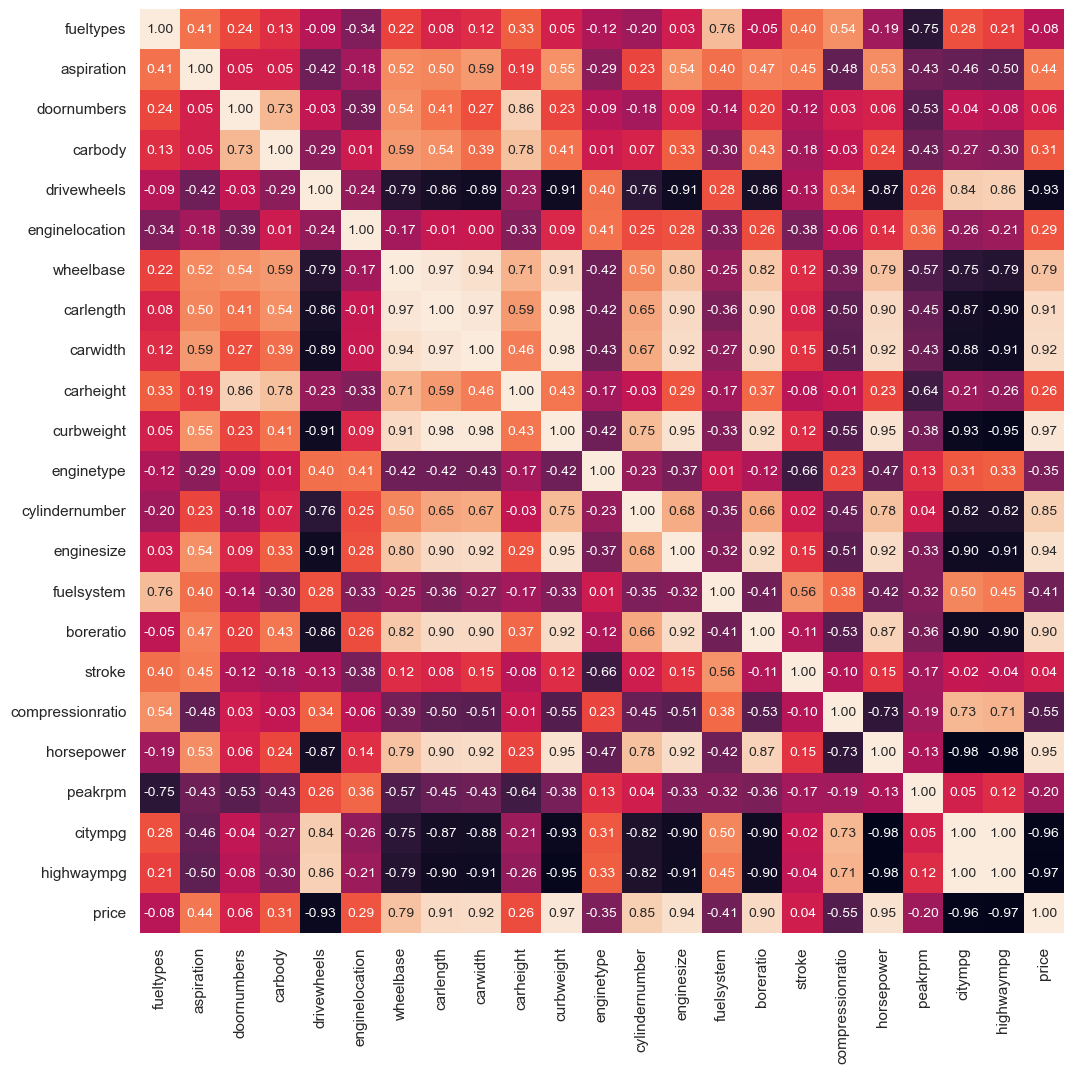

In [13]:
cormat = price_df.corr().round(2)
cm = np.corrcoef(cormat.values.T).round(2)


fig, ax = plt.subplots(figsize=(30,12))

sns.set(font_scale = 1)
hm = sns.heatmap(cm,ax = ax, annot = True, cbar=False, square = True,fmt = '.2f',annot_kws={'size':10},yticklabels = cormat.columns, xticklabels=cormat.columns)
plt.show()

#### Positive coefficient
It means proportional i.e. when a unit is added to the independent variable, a coefficient times unit is added to the dependent variable. 
+ Horsepower: more horsepower implies a higher price. So it is a possitive correlation of 0.95. It is a very high correlation. 

And... that's all. Even though variables like *carwidth*, *enginesize* and *cylindernumber* have a high correlation with price, they also have a high correlation with horsepower. In consequence they can't be used in the model due to a Multicollinearity issue. Multicollinearity occurs when 2 or more independent variables are related. 

#### Negative coefficient
It means inverse proportionality, so everytime our independent variable increases, the dependent variable will decrease. In this case, the following variables can be used: 
+ Compression ratio: it looks like a contradiction, but it can be used in the model because in real life, a higher compression ratio means way more efficiency, and expensive cars use a lot of fuel. In consequence, expensive cars will be less efficient and have a lower compression ratio. 

As we see in the heatmap from above, horsepower and price have a strong correlation with the other variables, and we will have to use this two for multipe regression analysis. More data can be collected in this case like car's color, brand or even date to evaluate seasons. 


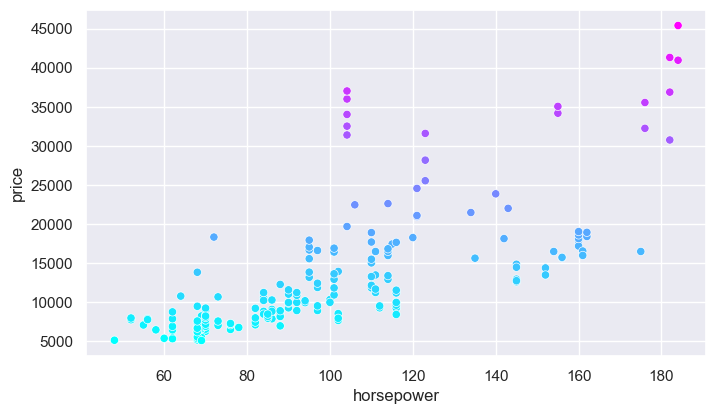

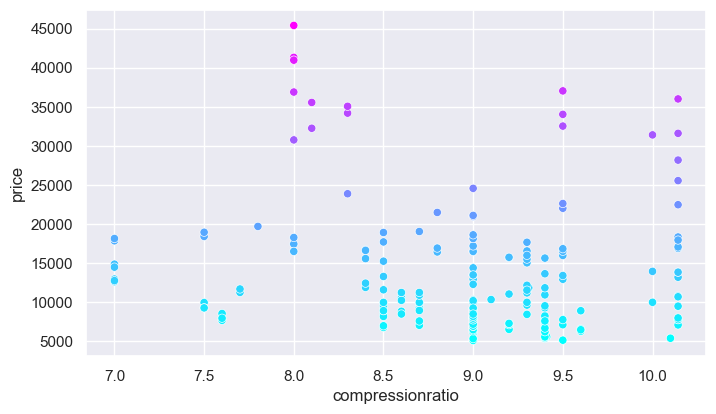

In [20]:
for x in ['horsepower','compressionratio']: 
    plt.figure(figsize=(8,4.5))
    sns.scatterplot(data=price_df,x = horse, y = 'price', hue= 'price', palette = 'cool', legend = False)

### Regression Analysis

Importing SckitLearn library to train the model

In [16]:
from sklearn.model_selection import train_test_split

In [27]:
reg_data = price_df[['horsepower', 'compressionratio']]

In [32]:
reg_target = pd.DataFrame(price_df['price'])

In [35]:
x_train,x_test, y_train, y_test = train_test_split(reg_data,reg_target,test_size = 0.1, random_state = 1)

In [37]:
x_train.shape

(184, 2)

In [38]:
x_test.shape

(21, 2)

In [39]:
y_train.shape

(184, 1)

In [40]:
x_test.shape

(21, 2)

In [41]:
reglin = LinearRegression()

In [42]:
reglin.fit(X= x_train, y = y_train)

LinearRegression()

In [62]:
h, c = reglin.coef_[0]
print(f'Coefficient (HorsePower): {h}')
print(f'Coefficient (Compression Ratio): {c}')
print(f'\nIntercept: {reglin.intercept_[0]}')
print(f'\nFormula: y = {h:.2f}*Horse Power + {c:.2f}*Compression {reglin.intercept_[0]:.2f}')

Coefficient (HorsePower): 208.34535204961486
Coefficient (Compression Ratio): 2866.6006048303166

Intercept: -33333.06389818756

Formula: y = 208.35*Horse Power + 2866.60*Compression -33333.06


In [83]:
prediction = reglin.predict(x_test)

In [117]:
expected = y_test
expected = expected.reset_index().drop('index',axis=1)

In [100]:
prediction = pd.DataFrame(prediction)

In [102]:
prediction.columns = ['price']

In [119]:
df = pd.DataFrame()

In [120]:
df['expected'] = expected

In [125]:
df['prediction'] = prediction

In [132]:
prediction.min()

price    3900.218746
dtype: float64

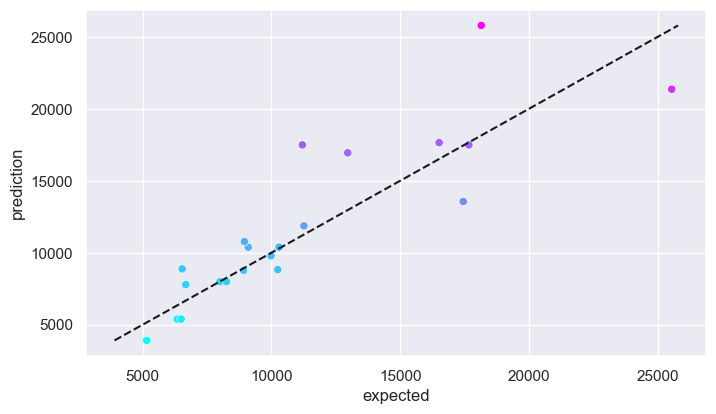

In [133]:
figura = plt.figure(figsize = (8,4.5))

axes = sns.scatterplot(data=df, x='expected',y='prediction',hue='prediction', palette = 'cool', legend = False)

start = min(df.expected.min(),df.prediction.min())
end = max(df.expected.max(),df.prediction.max())

line = plt.plot([start,end], [start,end],'k--')

### METRICS

In [134]:
from sklearn import metrics

In [138]:
metrics.r2_score(df.expected,df.prediction)

0.6858625324793024

This means 68% of data is predicted for our model. It is actually a good number, considering it only has 2 variables and not much context.